# DataSet 구성

In [1]:
import re
import pandas as pd
import pymysql.cursors
from sqlalchemy import true
import numpy as np

import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

##### 자연광 데이터 처리

In [2]:
def load_sunRS(year, month, day):
    connection = pymysql.connect(host='210.102.142.14', port=3306, user='witlab', passwd='defacto8*',
                                 charset='utf8', autocommit=True,
                                 cursorclass=pymysql.cursors.DictCursor)
    cursor = connection.cursor()
    target_date = year + '-' + month + '-' + day
    sql = "SELECT * FROM naturallight.sun_info WHERE Date='" + '%s' % target_date + "'"
    # print(sql)
    cursor.execute(sql)
    result = cursor.fetchall()
    df = pd.DataFrame(result)
    # print(df)
    df["Sunup_Time"] = df["Sunup_Time"].astype(str)
    df["Sunup_Time"] = df["Sunup_Time"].apply(lambda x: re.sub("0 days ", "", x))
    df["Sunup_Time"] = df["Sunup_Time"].apply(lambda x: re.sub("00.000000000", "00", x))

    df["Sundown_Time"] = df["Sundown_Time"].astype(str)
    df["Sundown_Time"] = df["Sundown_Time"].apply(lambda x: re.sub("0 days ", "", x))
    df["Sundown_Time"] = df["Sundown_Time"].apply(lambda x: re.sub("00.000000000", "00", x))
    # print(df)
    cursor.close()
    return df

def load_cas_data(sunRS_df, year, month, day):
    connection = pymysql.connect(host='210.102.142.14', port=3306, user='witlab', passwd='defacto8*',
                                 charset='utf8', autocommit=True,
                                 cursorclass=pymysql.cursors.DictCursor)
    cursor = connection.cursor()

    target_date = year + '-' + month + '-' + day

    sql = "SELECT Date as Timestamp, cct FROM cas_db.natural_tracker WHERE date(Date)='" + '%s' % target_date + "' and time(date) >= '" + \
          sunRS_df["Sunup_Time"][0] + "'and time(date) <= '" + sunRS_df["Sundown_Time"][0] + "' ORDER BY DATE"

    # print(sql)
    cursor.execute(sql)
    result = cursor.fetchall()
    natural_tracker = pd.DataFrame(result)
    # print(natural_tracker)
    cursor.close()
    return natural_tracker

def check_minimum(array):
    start = np.argmin(array[:int(len(array) / 2)])
    end = np.argmin(array[int(len(array) / 2):]) + int(len(array) / 2)
    return start, end


def noise_off(Cas_df):
    scaled = []
    day_df = Cas_df['Timestamp']
    for_scale = np.arange(len(day_df))
    scaler = MinMaxScaler()
    scaled_val = scaler.fit_transform(np.reshape(for_scale, (-1, 1)))
    scaled_val = np.reshape(scaled_val, (-1))

    for j in range(len(scaled_val)):
        scaled.append(scaled_val[j])

    # Cas_df['scaled'] = scaled

    start, end = check_minimum(Cas_df['cct'].values)
    day_data = Cas_df.values[start:end]
    # print(Cas_df)
    # print(day_data)
    noise_off_df = pd.DataFrame(data=day_data, columns=Cas_df.columns)

    noise_off_df["Timestamp"] = noise_off_df["Timestamp"].astype(str)
    noise_off_df['Timestamp'] = pd.to_datetime(noise_off_df['Timestamp']).values.astype(np.int64) // 10 ** 9

    return noise_off_df

##### TadGAN 데이터 구성 함수

In [3]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)


def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size
    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

##### Processor

In [4]:
def process(year, month, day):
    ## db별 df로드 ##
    sunRS_df = load_sunRS(year, month, day)
    Cas_df = load_cas_data(sunRS_df, year, month, day)
    return noise_off(Cas_df)


def onedays_csv(date_list, save_path):
    total_df = pd.DataFrame()

    for i in date_list:
        print(i)
        year = str(i).split("-")[0][-4:]
        month = str(i).split("-")[1]
        day = str(i).split("-")[2]
        target_date = year + '-' + month + '-' + day
        temp_df = process(year, month, day)

        # temp_df = temp_df.sort_values('Timestamp').set_index('Timestamp')
        # temp_np = temp_df.values

        # 여기서 끊자.
        temp_df.to_csv(f'{save_path}\\basic_{i}.csv', sep=',', na_rep='NaN', index=False)


# 2. 그리고 이후에 슬라이딩 윈도우하고나서 원래 데이터가 만들어지는 형식으로 교체를 해야함. 이과정에서 numpyarray를 다시 csv로 빼야하는데 3차원 데이터인 x가 그게 필요없는지 확인. 나머지는 원본처럼 바꿔줘야함.


def make_nbarrays():
    original_path = 'C:\\Users\\GAKA\\Desktop\\csv_test\\'
    file_list = os.listdir(original_path)
    img_list = []
    for item in file_list:
        if item.find('.csv') is not -1:
            img_list.append(item)

    # out_X = np.array()
    # out_y = np.array()
    # out_X_index = np.array()
    # out_y_index = np.array()

    scaler = MinMaxScaler(feature_range=(-1, 1))
    for i in img_list:
        print(i)
        temp_df = pd.read_csv('C:\\Users\\GAKA\\Desktop\\csv_test\\' + i)
        # print(temp_df.shape)
        X, index = time_segments_aggregate(temp_df, interval=1, time_column='Timestamp')

        X = scaler.fit_transform(X)
        X, y, X_index, y_index = rolling_window_sequences(X, index,
                                                          window_size=100,
                                                          target_size=1,
                                                          step_size=1,
                                                          target_column=0)
        # print(X.shape, y.shape, X_index.shape, y_index.shape)
        # print(y_index)

        if i == 'basic_2017-05-17.csv':
            out_X = X
            out_y = y
            out_X_index = X_index
            out_y_index = y_index
        elif i != 0:
            out_X = np.concatenate((out_X, X), axis=0)
            out_y = np.concatenate((out_y, y), axis=0)
            out_X_index = np.concatenate((out_X_index, X_index), axis=0)
            out_y_index = np.concatenate((out_y_index, y_index), axis=0)

        # print(out_X.shape, out_y.shape, out_X_index.shape, out_y_index.shape)

    out_X_index = np.array(range(1, len(out_X) + 1))
    out_y_index = np.array(range(101, len(out_X) + 101))

    return out_X, out_y, out_X_index, out_y_index

    # total_df.to_csv('C:\\Users\\GAKA\\Desktop\\noise_off_oneday_sc.csv', sep=',', na_rep='NaN', index=False)


def make_underzero_reverse_df(df):
    reverse_df = df[::-1]
    reverse_df['cct'] = reverse_df.apply(lambda x: x['cct'] * -1, axis=1)
    return reverse_df


def make_v20_df_csv(save_path):
    first = True
    first_name = ""
    file_list = os.listdir(save_path)
    img_list = []
    scaler = MinMaxScaler(feature_range=(0, 1))

    total_df = pd.DataFrame()
    old_reverse_df = pd.DataFrame()

    for item in file_list:
        if item.find('.csv') is not -1:
            img_list.append(item)
            if first:
                first = False
                first_name = item


    for i in img_list:
        temp_df = pd.read_csv(f'{save_path}\\{i}')
        temp_df = temp_df.reset_index(drop=true)
        temp_df['Timestamp'] = temp_df.apply(lambda x: float(x.name) + 1, axis=1)
        temp_df = temp_df[['Timestamp', 'cct']]
        temp_np = temp_df.values
        temp_np = scaler.fit_transform(temp_np)
        temp_df = pd.DataFrame(temp_np, columns=['Timestamp', 'cct'])

        if i == first_name:
            old_reverse_df = make_underzero_reverse_df(temp_df.copy())
            oneday_df = old_reverse_df.copy()

            oneday_df = oneday_df.append(temp_df)
            oneday_df = oneday_df.append(old_reverse_df)

            total_df = oneday_df

        elif i != first_name:

            oneday_df = temp_df.copy()

            old_reverse_df = make_underzero_reverse_df(temp_df.copy())
            oneday_df = oneday_df.append(old_reverse_df)

            total_df = total_df.append(oneday_df)

        print(i + ": 완료")

    return total_df

def test_mode():
    scaler = MinMaxScaler(feature_range=(0, 1))

    total_df = pd.DataFrame()
    old_reverse_df = pd.DataFrame()

    temp_df = pd.read_csv('C:\\Users\\GAKA\\Desktop\\TadGAN\\#. test_sets\\test_cct.csv')
    temp_np = temp_df.values
    temp_np = scaler.fit_transform(temp_np)
    temp_df = pd.DataFrame(temp_np, columns=['Timestamp', 'cct'])

    old_reverse_df = make_underzero_reverse_df(temp_df.copy())
    oneday_df = old_reverse_df.copy()

    oneday_df = oneday_df.append(temp_df)
    oneday_df = oneday_df.append(old_reverse_df)

    oneday_df.to_csv('C:\\Users\\GAKA\\Desktop\\test_cct_reverse_onesc.csv', sep=',', na_rep='NaN', index=False)


def insert_gap(df):
    start =0
    while true:
        count = 0
        for i in range(start,len(df) - 1):
            # if df['cct'][i] == -1 * (df['cct'][i + 1]):
            #     if abs(df['cct'][i]) + abs(df['cct'][i + 1]) == 0:
            #         continue
            #     print(i, "catch")
            #     count = count + 1

            # if abs(df['cct'][i] - df['cct'][i + 1]) >= 0.08:
            #     count = count + 1

            if ((df['cct'][i]>=0 and df['cct'][i+1]<0) or (df['cct'][i+1]>=0 and df['cct'][i]<0)) and (abs(df['cct'][i] - df['cct'][i + 1]) >= 0.08):
                count = count + 1


                if (df['cct'][i] < df['cct'][i + 1]):
                    print('gap')
                    print(df['Timestamp'][i], df['Timestamp'][i + 1])
                    print(df['cct'][i], df['cct'][i + 1])
                    temp = df[(df['cct'] >= df['cct'][i]) & (df['cct'] <= df['cct'][i + 1])]
                    # plt.scatter(temp['Timestamp'], temp['cct'], marker='o', s=1)
                    # plt.title(
                    #     str(df['Timestamp'][i]) + "," + str(df['Timestamp'][i + 1]) + "," + str(
                    #         df['cct'][i]) + "," + str(
                    #         df['cct'][i + 1]))
                    # plt.show()

                # 위아래 범위값에서 dataframe을 잘라낸 이후
                # timestamp 기준으로 연속된 값만 확인해서 그걸로 max_len과 temp_df를 가지고 keep.

                else:
                    print('gap')
                    print(df['Timestamp'][i], df['Timestamp'][i + 1])
                    print(df['cct'][i], df['cct'][i + 1])
                    temp = df[(df['cct'] <= df['cct'][i]) & (df['cct'] >= df['cct'][i + 1])]
                    # plt.scatter(temp['Timestamp'], temp['cct'], marker='o', s=1)
                    # plt.title(
                    #     str(df['Timestamp'][i]) + "," + str(df['Timestamp'][i + 1]) + "," + str(
                    #         df['cct'][i]) + "," + str(
                    #         df['cct'][i + 1]))
                    # plt.show()



                # 가장 긴거
                final_start_index = 0
                final_end_index = 0
                max_len = 0

                # 직전 세트
                start_index = 0

                temp = temp.reset_index(drop=true)

                for j in range(len(temp) - 1):
                    if 1 < abs(temp['Timestamp'][j] - temp['Timestamp'][j + 1]):
                        if final_end_index == 0:
                            start_index = j + 1
                            final_end_index = j
                            max_len = final_end_index - final_start_index

                        else:
                            if max_len > j - start_index:
                                start_index = j + 1
                            else:
                                max_len = j - start_index
                                final_start_index = start_index
                                start_index = j+1
                                final_end_index = j


                # temp.to_csv(
                #     'C:\\Users\GAKA\\Desktop\\nd_temp.csv',
                #     sep=',', na_rep='NaN', index=False)
                head = df[0:i + 1].copy()
                head = head[['Timestamp','cct']]


                mid_df = temp[final_start_index:final_end_index].copy()
                mid_df = mid_df[['Timestamp','cct']]
                mid_df = mid_df.reset_index(drop=true)
                mid_df['Timestamp'] = mid_df.apply(lambda x: float(x.name) + 1, axis=1)


                if (df['cct'][i] < df['cct'][i + 1]):
                    # print(mid_df['cct'])
                    if(mid_df['cct'][0] > mid_df['cct'][len(mid_df)-1]):
                        mid_df = mid_df[::-1]
                        mid_df = mid_df.reset_index(drop=true)

                if (df['cct'][i] > df['cct'][i + 1]):
                    # print("2")
                    if(mid_df['cct'][0] < mid_df['cct'][len(mid_df)-1]):
                        mid_df = mid_df[::-1]
                        mid_df = mid_df.reset_index(drop=true)

                print(len(mid_df) - 1,"추가!")

                tail = df[i+1:len(df)-1].copy()
                tail = tail[['Timestamp','cct']]

                df = head.append(mid_df)
                df = df.append(tail)

                df = df.reset_index(drop=true)
                df['Timestamp'] = df.apply(lambda x: float(x.name) + 1, axis=1)

                plt.scatter(df['Timestamp'], df['cct'], marker='o', s=1)
                plt.show()
                start = len(mid_df) - 1 + i
                break
        if count == 0:
            break

    return df

##### data main

2020-06-29


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-09-13


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-10-23


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-10-24


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-10-26


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-10-27


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-10-28


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-10-30


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-02


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-04


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-09


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-10


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-11


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-12


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-16


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-23


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-25


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-11-28


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-01


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-08


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-09


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-12


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-14


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-15


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-16


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-17


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-19


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-20


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-28


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2020-12-31


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-02


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-07


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-08


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-09


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-10


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-13


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-14


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-17


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-19


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-20


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-24


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-01-29


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-02


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-03


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-04


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-08


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-11


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-12


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-13


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-18


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-19


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-20


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-21


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-23


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-26


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-02-27


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-03


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-05


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-09


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-10


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-13


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-16


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-17


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-18


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-22


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-23


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-24


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-25


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-29


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-30


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-03-31


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-05-30


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-06-04


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-06-09


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2021-07-02


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


basic_2020-06-29.csv: 완료
basic_2020-09-13.csv: 완료
basic_2020-10-23.csv: 완료
basic_2020-10-24.csv: 완료
basic_2020-10-26.csv: 완료
basic_2020-10-27.csv: 완료
basic_2020-10-28.csv: 완료
basic_2020-10-30.csv: 완료
basic_2020-11-02.csv: 완료
basic_2020-11-04.csv: 완료
basic_2020-11-09.csv: 완료
basic_2020-11-10.csv: 완료
basic_2020-11-11.csv: 완료
basic_2020-11-12.csv: 완료
basic_2020-11-16.csv: 완료
basic_2020-11-23.csv: 완료
basic_2020-11-25.csv: 완료
basic_2020-11-28.csv: 완료
basic_2020-12-01.csv: 완료
basic_2020-12-08.csv: 완료
basic_2020-12-09.csv: 완료
basic_2020-12-12.csv: 완료
basic_2020-12-14.csv: 완료
basic_2020-12-15.csv: 완료
basic_2020-12-16.csv: 완료
basic_2020-12-17.csv: 완료
basic_2020-12-19.csv: 완료
basic_2020-12-20.csv: 완료
basic_2020-12-28.csv: 완료
basic_2020-12-31.csv: 완료
basic_2021-01-02.csv: 완료
basic_2021-01-07.csv: 완료
basic_2021-01-08.csv: 완료
basic_2021-01-09.csv: 완료
basic_2021-01-10.csv: 완료
basic_2021-01-13.csv: 완료
basic_2021-01-14.csv: 완료
basic_2021-01-17.csv: 완료
basic_2021-01-19.csv: 완료
basic_2021-01-20.csv: 완료


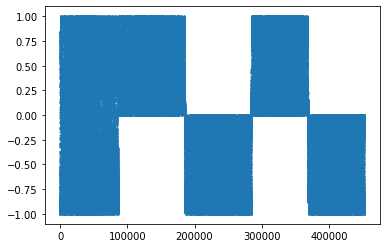

gap
4964.0 4965.0
-0.05739680533988645 0.04893055397967505
348 추가!


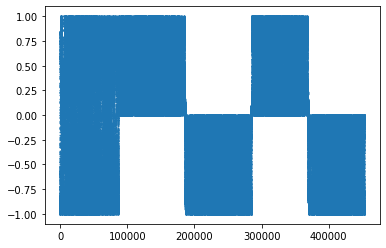

gap
5313.0 5314.0
-0.05436192372692639 0.04893055397967505
338 추가!


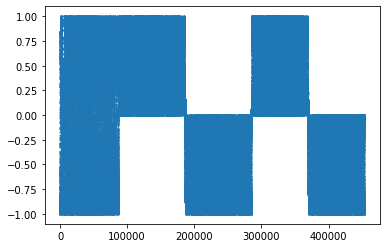

gap
5652.0 5653.0
-0.049883620896708836 0.04893055397967505
322 추가!


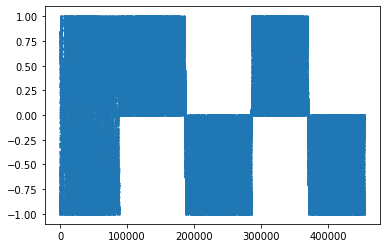

gap
5975.0 5976.0
-0.0427135442574641 0.04893055397967505
321 추가!


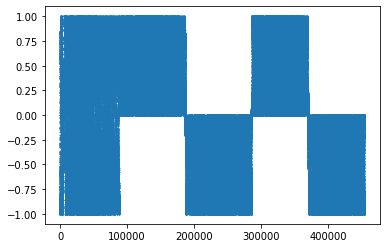

gap
7525.0 7526.0
-0.04893055397967505 0.05426041586242469
643 추가!


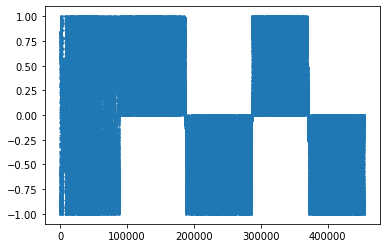

gap
9391.0 9392.0
-0.05426041586242469 0.2445621393255675
1013 추가!


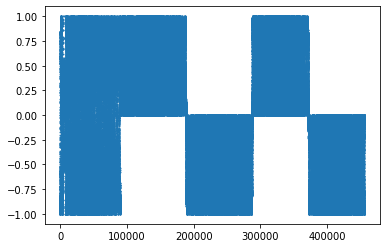

gap
11553.0 11554.0
-0.2445621393255675 0.0
1011 추가!


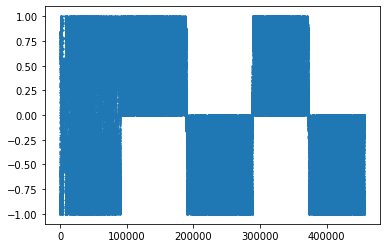

gap
13080.0 13081.0
0.07835939993616359 -0.07835939993616359
1337 추가!


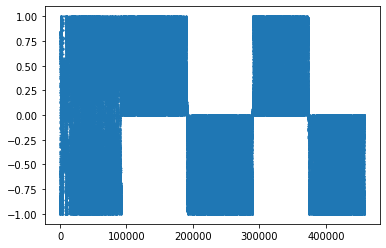

gap
15855.0 15856.0
-0.7129217472165854 0.0
1525 추가!


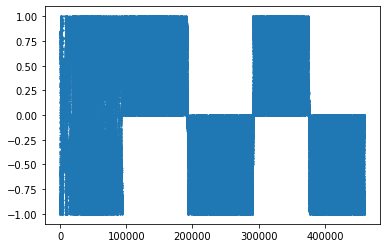

gap
17381.0 17382.0
-0.5 0.0
1401 추가!


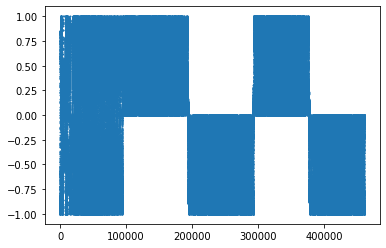

gap
18783.0 18784.0
-0.5 0.0
2803 추가!


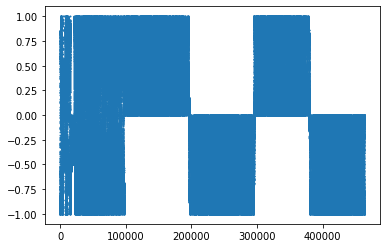

gap
21587.0 21588.0
-0.5 0.0
5607 추가!


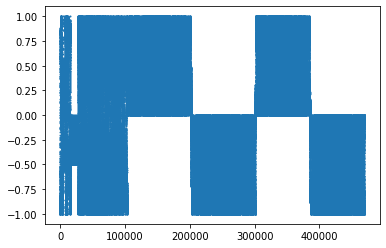

gap
27195.0 27196.0
-0.5 0.0
11215 추가!


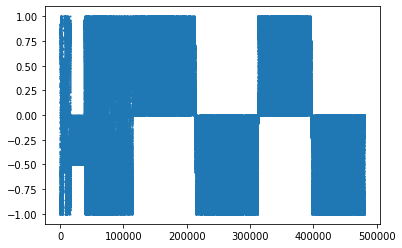

gap
38411.0 38412.0
-0.5 0.0
22431 추가!


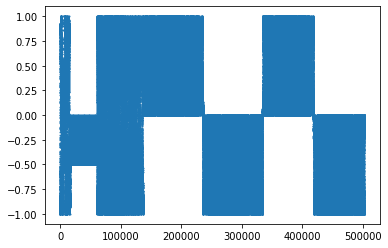

gap
60843.0 60844.0
-0.5 0.0
44863 추가!


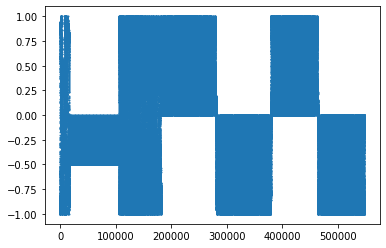

gap
105707.0 105708.0
-0.5 0.0
89727 추가!


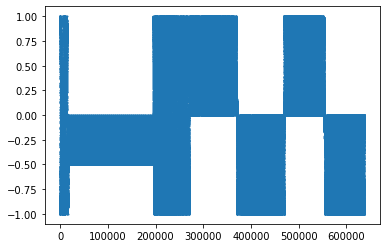

gap
195435.0 195436.0
-0.5 0.0
179455 추가!


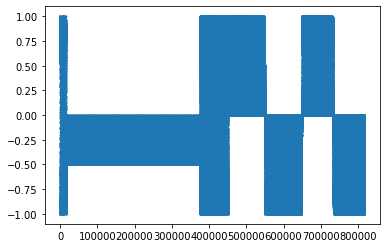

gap
374891.0 374892.0
-0.5 0.0
358911 추가!


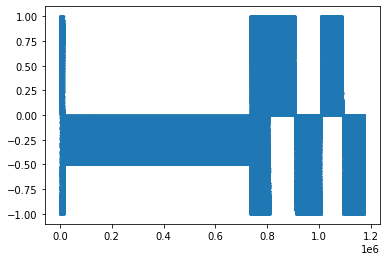

gap
733803.0 733804.0
-0.5 0.0
717823 추가!


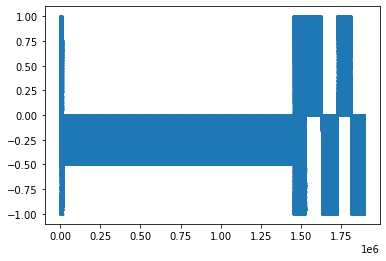

gap
1451627.0 1451628.0
-0.5 0.0


KeyboardInterrupt: 

In [5]:
# step1
# date_list = ["2017-05-17", "2017-09-14", "2017-10-20", "2017-12-13",
#              "2017-12-25", "2018-02-17", "2018-02-26", "2018-04-28", "2018-05-26", "2018-06-01", "2018-06-06",
#              "2018-11-03", "2018-12-14", "2018-12-27", "2019-02-21", "2019-03-01", "2019-04-04", "2019-05-07",
#              "2019-05-24", "2019-10-20", "2020-02-20", "2020-03-12", "2020-04-08", "2020-04-24"]
# date_list = ["2020-04-09"]
# date_list = ["2020-01-14","2020-02-27","2020-03-19","2020-07-05","2020-07-06","2020-11-27","2021-02-16","2021-02-17",]
parent_path = 'D:\\DeepLeaning\\TadGAN\\Shin\\Dataset'
date_list_path = os.path.join(parent_path, '15per_dataset(new)')
date_list = os.listdir(date_list_path)
date_list = [x[:-4] for x in date_list if(x.find('result')==-1)]

save_path = os.path.join(parent_path, '15per_dataset(new)_shin')
if not os.path.exists(save_path):
    os.mkdir(save_path)
onedays_csv(date_list, save_path)

# step2(최신)
df = make_v20_df_csv(save_path)
df = df.reset_index(drop=true)
df['Timestamp'] = df.apply(lambda x: float(x.name) + 1, axis=1)
df.to_csv(f'{save_path}\\result_make_index.csv', sep=',', na_rep='NaN', index=False)

# step3
df = pd.read_csv(f'{save_path}\\result_make_index.csv')
df = insert_gap(df)
df.to_csv(f'{save_path}\\result_insert_gap.csv', sep=',', na_rep='NaN', index=False)
# test_mode()

# TadGAN 학습

In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from utils import plot_ts, plot_rws

from model import hyperparameters
from orion.primitives.tadgan import TadGAN

Using TensorFlow backend.


In [2]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

In [3]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

In [4]:
parent_path = 'D:\\DeepLeaning\\TadGAN\\Shin\\Dataset\\15per_dataset(new)_shin'
data_path = os.path.join(parent_path, 'result_insert_gap.csv')
model_path = os.path.join(parent_path, 'model_result')
if not os.path.exists(model_path):
    os.mkdir(model_path)
total_df = pd.read_csv(data_path)
total_df.head(5)

,Timestamp,cct
0,1.0,-0.871665
1,2.0,-0.879156
2,3.0,-0.895323
3,4.0,-0.903264
4,5.0,-0.908056


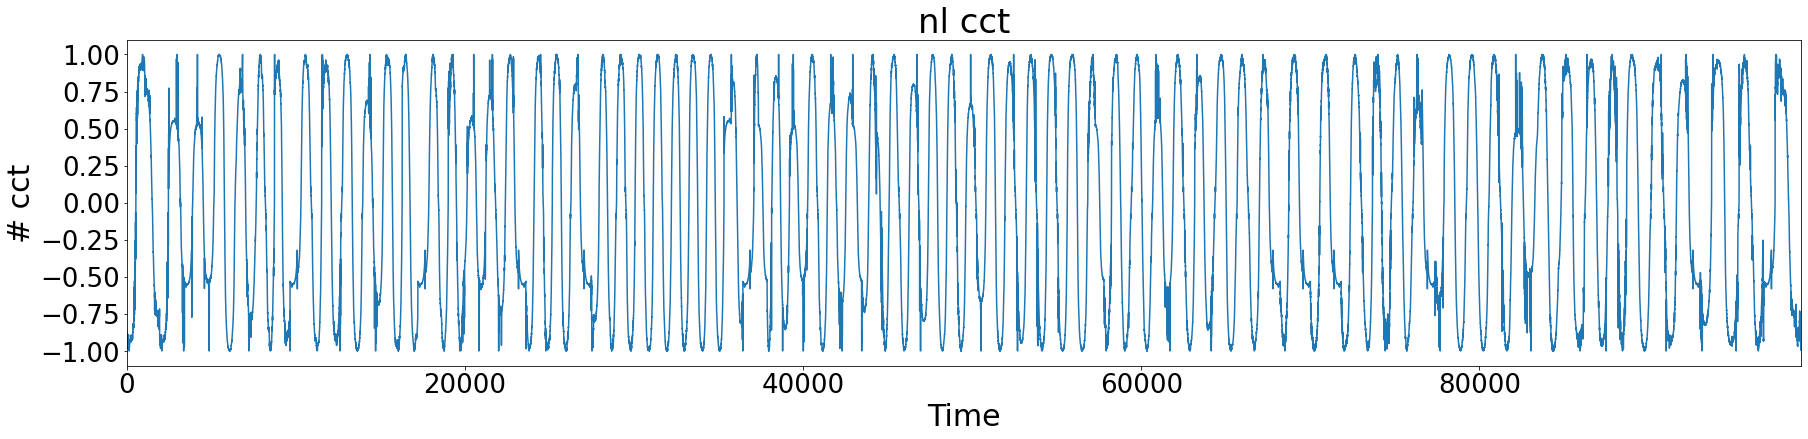

array([[-0.87166497],
       [-0.87915588],
       [-0.8953235 ],
       ...,
       [-0.96456822],
       [-0.96644003],
       [-0.96780328]])

In [5]:
X, index = time_segments_aggregate(total_df, interval=1, time_column='Timestamp')
imp = SimpleImputer()
X = imp.fit_transform(X)
plot_ts(X)
X

In [6]:
X, y, X_index, y_index = rolling_window_sequences(X, index,
                                                  window_size=100,
                                                  target_size=1,
                                                  step_size=1,
                                                  target_column=0)
# plot_rws(X)

In [7]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64
hyperparameters

{'epochs': 100,
 'shape': (100, 1),
 'optimizer': 'keras.optimizers.Adam',
 'learning_rate': 0.0005,
 'latent_dim': 20,
 'batch_size': 64,
 'n_critic': 5,
 'encoder_input_shape': (100, 1),
 'generator_input_shape': (20, 1),
 'critic_x_input_shape': (100, 1),
 'critic_z_input_shape': (20, 1),
 'encoder_reshape_shape': (20, 1),
 'generator_reshape_shape': (50, 1),
 'layers_encoder': [{'class': 'keras.layers.Bidirectional',
   'parameters': {'layer': {'class': 'keras.layers.LSTM',
     'parameters': {'units': 100, 'return_sequences': True}}}},
  {'class': 'keras.layers.Flatten', 'parameters': {}},
  {'class': 'keras.layers.Dense', 'parameters': {'units': 20}},
  {'class': 'keras.layers.Reshape',
   'parameters': {'target_shape': 'encoder_reshape_shape'}}],
 'layers_generator': [{'class': 'keras.layers.Flatten', 'parameters': {}},
  {'class': 'keras.layers.Dense', 'parameters': {'units': 50}},
  {'class': 'keras.layers.Reshape',
   'parameters': {'target_shape': 'generator_reshape_shape'}}

In [8]:
y_change = X[:,:, [0]]
y, y_change

(array([[-0.96368625],
        [-0.96649943],
        [-0.96719046],
        ...,
        [-0.96456822],
        [-0.96644003],
        [-0.96780328]]),
 array([[[-0.87166497],
         [-0.87915588],
         [-0.8953235 ],
         ...,
         [-0.95025004],
         [-0.95505453],
         [-0.95919661]],
 
        [[-0.87915588],
         [-0.8953235 ],
         [-0.90326419],
         ...,
         [-0.95505453],
         [-0.95919661],
         [-0.96368625]],
 
        [[-0.8953235 ],
         [-0.90326419],
         [-0.90805641],
         ...,
         [-0.95919661],
         [-0.96368625],
         [-0.96649943]],
 
        ...,
 
        [[-0.87158492],
         [-0.87376869],
         [-0.87590118],
         ...,
         [-0.96236736],
         [-0.96039299],
         [-0.96141009]],
 
        [[-0.87376869],
         [-0.87590118],
         [-0.87735845],
         ...,
         [-0.96039299],
         [-0.96141009],
         [-0.96456822]],
 
        [[-0.87590118],
   

In [9]:
tgan = TadGAN(**hyperparameters)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
X.shape, y.shape, y_change.shape 

((98930, 100, 1), (98930, 1), (98930, 100, 1))

In [11]:
tgan.fit(X, y_change)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\user\anaconda3\envs\TadGAN\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1/100, [Dx loss: [ -1.834658    9.18111   -11.478709    0.0462947]] [Dz loss: [-3.3171177  -2.2049289  -1.7721878   0.06599993]] [G loss: [16.525002   11.7002      1.94899     0.28758147]]
Epoch: 2/100, [Dx loss: [-0.5716369   3.2128763  -3.965356    0.01808423]] [Dz loss: [-3.3540437  -3.9561088   0.15488584  0.0447181 ]] [G loss: [ 4.800225    3.9641469  -0.1110993   0.09471768]]
Epoch: 3/100, [Dx loss: [-0.44293058  0.51593053 -1.1144103   0.01555546]] [Dz loss: [-3.388691   -4.2684245   0.42536053  0.04543719]] [G loss: [ 1.5055486   1.1852198  -0.38818818  0.07085185]]
Epoch: 4/100, [Dx loss: [-2.72908479e-01 -1.39274158e+01  1.35215025e+01  1.32995090e-02]] [Dz loss: [-3.497307   -4.734192    0.78273296  0.04541485]] [G loss: [-13.685167   -13.542931    -0.7593737    0.06171348]]
Epoch: 5/100, [Dx loss: [-0.39104494  5.8217297  -6.371744    0.01589649]] [Dz loss: [-3.2870514  -4.282267    0.53618884  0.04590272]] [G loss: [ 6.7587347   6.6233935  -0.49457306  0.06299154]]


In [12]:
tgan.encoder.save_weights(f"{model_path}\\encoder_save_weights_5_2_5per(new)_shin.h5")
tgan.generator.save_weights(f"{model_path}\\generator_save_weights_5_2_5per(new)_shin.h5")
tgan.critic_x.save_weights(f"{model_path}\\critic_x_save_weights_5_2_5per(new)_shin.h5")
tgan.critic_z.save_weights(f"{model_path}\\critic_z_save_weights_5_2_5per(new)_shin.h5")

# TadGAN Predict

AttributeError: 'TadGAN' object has no attribute 'encoder_input_shape'

In [19]:
print('heelo')

heelo
